## Custom Optimizer SGD in Pytorch

In [ ]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CustomOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        # Define default hyperparameters
        defaults = dict(lr=lr)
        super(CustomOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        # Optional closure for reevaluating the model (e.g., for line search)
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Iterate over parameter groups
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # Simple gradient descent step
                p.add_(p.grad, alpha=-lr)
                #p.data = p.data - lr * p.grad
        return loss

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

In [ ]:
model = TwoLayerNet(5, 2, 1)
optimizer = CustomOptimizer(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [ ]:
x = torch.randn(32, 5)
y = torch.randn(32, 1)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)

optimizer.zero_grad()
loss.backward()

In [ ]:
before = model.fc1.weight.clone()
optimizer.step()
after = model.fc1.weight
print(before, after)

In [ ]:
print(len(optimizer.param_groups))
print()
print(optimizer.param_groups[0])
print()
print(optimizer.param_groups[0].keys())
print()
print(optimizer.param_groups[0]['lr'])
print()
print(optimizer.param_groups[0]['params'])
print()
print(len(optimizer.param_groups[0]['params']))
print()
print(optimizer.param_groups[0]['params'][0])
print(optimizer.param_groups[0]['params'][1])
print()
print(optimizer.param_groups[0]['params'][0].grad)
print(optimizer.param_groups[0]['params'][1].grad)

## Custom Adam Optimizer

In [ ]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class CustomAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid lr: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid eps: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                # State initialization
                state = self.state[p]
                if not state:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                # Update biased first moment estimate
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update biased second raw moment estimate
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Compute bias-corrected moments
                bias_correction1 = 1 - beta1 ** t
                bias_correction2 = 1 - beta2 ** t
                corrected_avg = exp_avg / bias_correction1
                corrected_avg_sq = exp_avg_sq / bias_correction2

                # Parameter update
                denom = corrected_avg_sq.sqrt().add_(eps)
                p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

In [ ]:
model = TwoLayerNet(5, 2, 1)
optimizer = CustomAdam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = torch.nn.MSELoss()

In [ ]:
x = torch.randn(32, 5)
y = torch.randn(32, 1)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)

optimizer.zero_grad()
loss.backward()

In [ ]:
before = model.fc1.weight.clone()
optimizer.step()
after = model.fc1.weight
print(before, after)

In [ ]:
print(len(optimizer.param_groups))
print()
print(optimizer.param_groups[0])
print()
print(optimizer.param_groups[0].keys())
print()
print(optimizer.param_groups[0]['lr'])
print()
print(optimizer.param_groups[0]['params'])
print()
print(len(optimizer.param_groups[0]['params']))
print()
print(optimizer.param_groups[0]['params'][0])
print(optimizer.param_groups[0]['params'][1])
print()
print(optimizer.param_groups[0]['params'][0].grad)
print(optimizer.param_groups[0]['params'][1].grad)

## Flora Adam

In [13]:
import contextlib
import logging
import math
from functools import partial
from typing import Any, Callable, Dict, Generator, Iterable, Optional, Sequence, Union
import torch
from torch.optim.optimizer import Optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
def stable_randn(
    shape: Union[int, Sequence[int]],
    seed: int,
    device: Optional[Union[str, torch.device]] = None,
    dtype: Optional[torch.dtype] = torch.float32,
) -> torch.Tensor:
    if device is None:
        device = torch.device("cpu")
    generator = torch.Generator(device=device).manual_seed(seed)
    rn = torch.randn(shape, generator=generator, device=generator.device, dtype=dtype)
    return rn

In [15]:
def next_seed(seed: int, adv: int = 0xF) -> int:
    """
    This is a naive helper function to generate a new seed from the given seed.
    """
    generator = torch.Generator().manual_seed(seed)
    return torch.randint(
        0, torch.iinfo(torch.int64).max, (adv,), generator=generator, device=generator.device
    ).tolist()[-1]

In [16]:
def split_seed(seed: int) -> tuple[int, int]:
    generator = torch.Generator().manual_seed(seed)
    return tuple(
        torch.randint(0, torch.iinfo(torch.int64).max, (2,), generator=generator, device=generator.device).tolist()
    )

In [17]:
class FloraAdam(Optimizer):
    def __init__(
        self,
        params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
        lr:float = None,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        rank: int = None,
        kappa: int = 1000,
        seed: int = 0,
    ) -> None:

        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "rank": rank,
            "kappa": kappa,

        }
        super().__init__(params, defaults)

        params_idx = seed
        for group in self.param_groups:
            for p in group["params"]:
                params_idx += 1
                if p.requires_grad:
                    self.state[p]["seed"] = params_idx

    @staticmethod
    def _should_compress(param_group: Dict, param_shape: tuple[int, ...]) -> tuple[bool, bool, bool]:
        factored = len(param_shape) == 2
        should_compress= (
            param_group["rank"] is not None
            and param_group["rank"] > 0
            and factored
            and min(param_shape) >= param_group["rank"]
            and max(param_shape) / min(param_shape) <= 4  # rule out embeddings
        )
        return should_compress

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                grad_shape = grad.shape
                should_compress = optimizer._should_compress(group, grad_shape)

                print('\n', 'grad_shape =', grad_shape)
                print('should_compress =', should_compress)

                state = self.state[p]

                # State initialization
                if (state and'step' not in state) or (not state):
                    state['step'] = 0

                    if should_compress:
                        if grad_shape[0] < grad_shape[-1]:
                            cshape = (group["rank"], grad_shape[-1])
                        else:
                            cshape = (grad_shape[0], group["rank"])

                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros(cshape).to(grad)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                    else:
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                if should_compress:
                    def _down_proj(seed, rank, tensor):
                        lseed, rseed = split_seed(seed)
                        if tensor.shape[0] < tensor.shape[-1]:
                            left_projection = stable_randn(
                                (rank, tensor.shape[0]),
                                seed=lseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)

                            return left_projection @ tensor
                        else:
                            right_projection = stable_randn(
                                (tensor.shape[-1], rank),
                                seed=rseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)
                        return tensor @ right_projection

                    def _up_proj(seed, rank, shape, ctensor):
                        lseed, rseed = split_seed(seed)
                        if shape[0] < shape[-1]:
                            left_projection = stable_randn(
                                (rank, shape[0]),
                                seed=lseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return left_projection.t() @ ctensor
                        else:
                            right_projection = stable_randn(
                                (shape[-1], rank),
                                seed=rseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return ctensor @ right_projection.t()

                    _current_seed = state["seed"]

                    cgrad = _down_proj(seed=_current_seed, rank=group["rank"], tensor=grad)
                    print('cgrad =', cgrad.shape)
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(cgrad, alpha=1 - beta1)
                    print('exp_avg =', exp_avg.shape)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                    print('exp_avg_sq =', exp_avg_sq.shape)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)

                    print('Decompr corrected_avg =', _up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg).shape)

                    p.addcdiv_(_up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg),
                              denom,
                              value=-lr)

                    # Time for a new seed
                    if state["step"] % group["kappa"] == 0:
                        _next_seed = next_seed(state["seed"])
                        print('Setting the new seed =', _next_seed)

                        state["exp_avg"].copy_(
                            _down_proj(
                                seed=_next_seed,
                                rank=group["rank"],
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=group["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                    ),
                            )
                        )

                        state["seed"] = _next_seed
                        _current_seed = _next_seed

                else:
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)
                    p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss


[Parameter containing:
tensor([[-0.1908,  0.0408, -0.1399,  0.2079, -0.1349,  0.0336,  0.1875,  0.2121,
         -0.0698,  0.0288, -0.0717, -0.1260, -0.2074,  0.1679,  0.0755, -0.0717,
          0.1984, -0.1820, -0.0527, -0.0198],
        [-0.0344, -0.0029,  0.1887, -0.2134, -0.0723,  0.0252,  0.0323,  0.0693,
          0.0470, -0.1491, -0.2102, -0.0953, -0.1536, -0.0656,  0.1811,  0.0018,
          0.2210,  0.0356,  0.1684,  0.0167],
        [-0.2107,  0.1744, -0.0412,  0.1555, -0.0150,  0.2104,  0.0578,  0.1808,
         -0.0129, -0.0435, -0.0388,  0.0521, -0.2107, -0.0892, -0.1347,  0.0798,
         -0.0156,  0.0866,  0.0767, -0.1063],
        [-0.1249, -0.1007,  0.1987,  0.2116, -0.0038, -0.2032, -0.0554,  0.0374,
          0.1073, -0.0478,  0.0276,  0.1678, -0.1792, -0.1667,  0.0168,  0.1976,
          0.2158, -0.0570,  0.0116,  0.0711],
        [ 0.0605, -0.2223,  0.0257, -0.1037,  0.0253,  0.1212, -0.0518, -0.0286,
         -0.1848, -0.0122,  0.0936,  0.1651, -0.1379, -0.0268,  

Training:   7%|▋         | 69/1000 [00:00<00:01, 686.29it/s]


 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress 

Training:  21%|██        | 209/1000 [00:00<00:01, 644.60it/s]


 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress 

Training:  34%|███▍      | 344/1000 [00:00<00:01, 640.97it/s]


 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress 

Training:  48%|████▊     | 475/1000 [00:00<00:00, 642.76it/s]

Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([1

Training:  61%|██████    | 606/1000 [00:00<00:00, 641.01it/s]


 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress 

Training:  73%|███████▎  | 734/1000 [00:01<00:00, 620.22it/s]

cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress

Training:  87%|████████▋ | 867/1000 [00:01<00:00, 608.11it/s]

Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([1

Training: 100%|██████████| 1000/1000 [00:01<00:00, 619.62it/s]

cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress = True
cgrad = torch.Size([2, 20])
exp_avg = torch.Size([2, 20])
exp_avg_sq = torch.Size([15, 20])
Decompr corrected_avg = torch.Size([15, 20])

 grad_shape = torch.Size([15])
should_compress = False

 grad_shape = torch.Size([10, 15])
should_compress = True
cgrad = torch.Size([2, 15])
exp_avg = torch.Size([2, 15])
exp_avg_sq = torch.Size([10, 15])
Decompr corrected_avg = torch.Size([10, 15])

 grad_shape = torch.Size([10])
should_compress = False

 grad_shape = torch.Size([15, 20])
should_compress

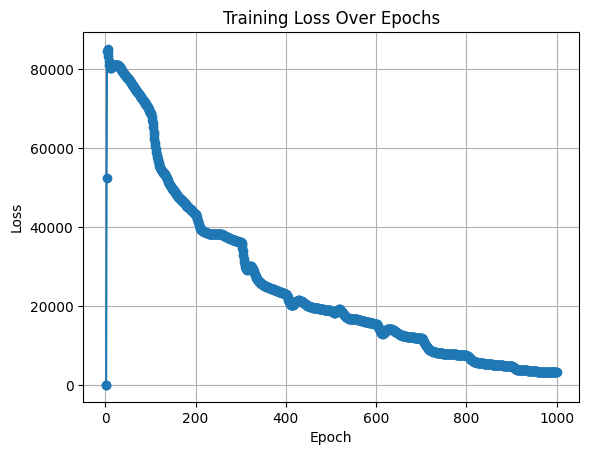

In [27]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities

model = TwoLayerNet(20, 15, 10)
optimizer = FloraAdam(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 2, kappa = 100, seed = 0)
criterion = torch.nn.MSELoss()

x = torch.randn(32, 20)
y = torch.randn(32, 10)

print(list(model.parameters()), '\n')

# Training step
output = model(x)
loss = criterion(output, y)
epochs = 1000

# Store loss for plotting
loss_values = []

for epoch in tqdm(range(epochs), desc="Training"):
    model.train()

    output = model(x)

    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

# Plot loss
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [ ]:
list(model.parameters())